# MFCC
MFCC는 음성 데이터에서의 고유한 feature임. mfcc feature를 머신러닝 모델에 넣어 결과를 확인해보고자 함

In [36]:
import itertools
import librosa
import librosa.display

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

In [37]:
midi_file = "/content/drive/MyDrive/GeneralMidi.wav"

In [38]:
instruments = [0, 10, 20, 30, 40 , 50, 60, 70, 80, 90]
num_notes = 50
sec = 2

audio = []
inst = []
for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument*num_notes*sec) + note*sec
  y, sr = librosa.load(midi_file, sr = None, offset=offset, duration=0.2)
  audio.append(y)
  inst.append(inst_idx)

In [39]:
audio_mfcc = []
for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr)
  audio_mfcc.append(ret)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0, flags=flags)


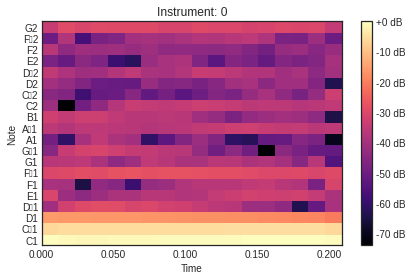

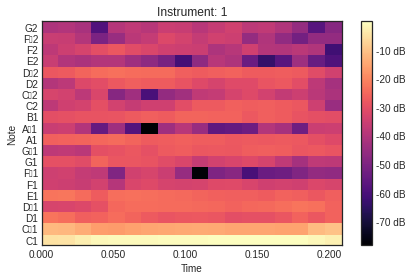

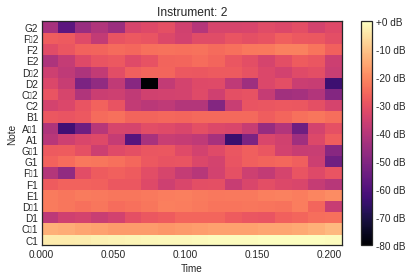

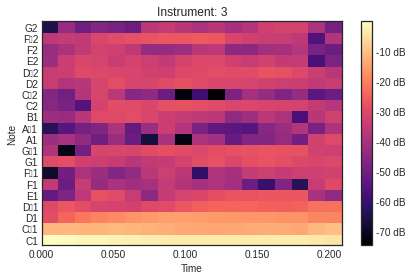

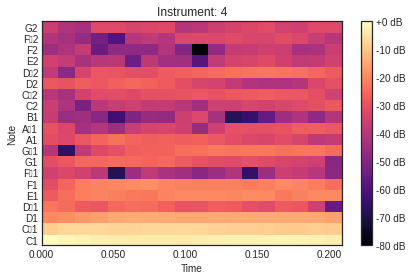

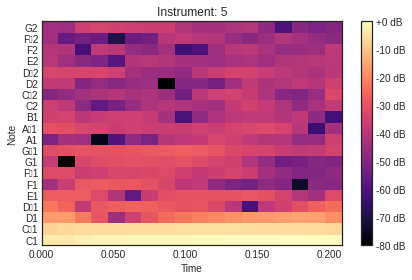

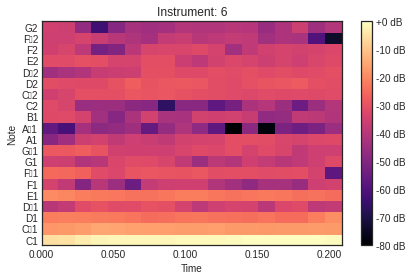

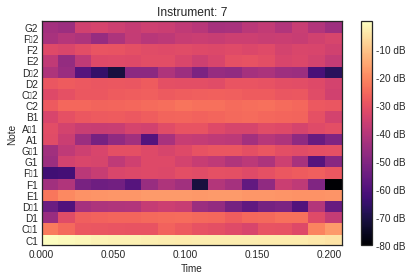

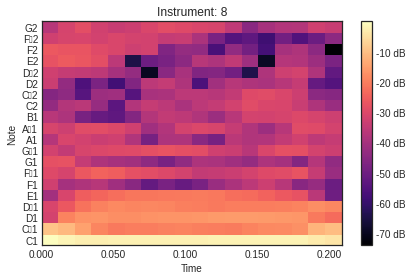

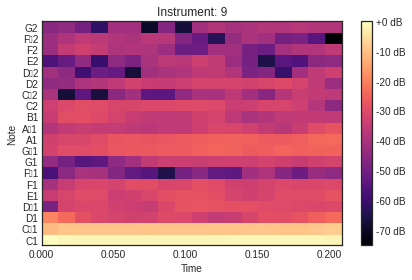

In [40]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

In [41]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)

(500, 20, 18) (500,)


In [42]:
mfcc_np = mfcc_np.reshape((500, 20*18))

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler()

In [44]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(mfcc_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 360)
(100, 360)
(400,)
(100,)


# Logistic Regression
-> logistic regression은 binary problem에 적합하지 다중 분류에는 적합하지 않음. 따라서 여기서는 적합한 모델이 아님.


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.94


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Support Vector Machine


In [46]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.98


# Decision Tree


In [47]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.87


## CNN 방법으로 처리해보기

In [48]:
from tensorflow.keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 20, 18, 1)
(100, 20, 18, 1)
(400, 10)
(100, 10)


In [49]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Input, Dense
from keras.models import Sequential, Model
def model_build():
  model = Sequential

  input = Input(shape=(20,18,1))

  output = Conv2D(128,3,strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)


  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer ='adam',
               loss = 'categorical_crossentropy',
               metrics=['acc'])
  return model


In [50]:
model = model_build()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 18, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 18, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 9, 128)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 9, 256)        295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 512)         1180

In [51]:
hist = model.fit(train_x, train_y, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 1s 111ms/step - loss: 23.4018 - acc: 0.1031 - val_loss: 28.3974 - val_acc: 0.1125
Epoch 2/100
3/3 [==============================] - 0s 32ms/step - loss: 20.4208 - acc: 0.0969 - val_loss: 4.0630 - val_acc: 0.0750
Epoch 3/100
3/3 [==============================] - 0s 32ms/step - loss: 3.3507 - acc: 0.1063 - val_loss: 2.3289 - val_acc: 0.0625
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 2.3307 - acc: 0.1469 - val_loss: 2.2425 - val_acc: 0.2250
Epoch 5/100
3/3 [==============================] - 0s 29ms/step - loss: 2.1972 - acc: 0.2281 - val_loss: 2.0852 - val_acc: 0.3000
Epoch 6/100
3/3 [==============================] - 0s 27ms/step - loss: 2.0640 - acc: 0.2969 - val_loss: 1.9535 - val_acc: 0.4125
Epoch 7/100
3/3 [==============================] - 0s 30ms/step - loss: 1.8928 - acc: 0.4344 - val_loss: 1.7407 - val_acc: 0.4625
Epoch 8/100
3/3 [==============================] - 0s 25ms/step - loss: 1.6763 - acc: 

In [52]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(14,5))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r:', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  loss = history_dict['acc']
  val_loss = history_dict['val_acc']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(14,5))

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(epochs, loss, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_loss, 'r:', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()


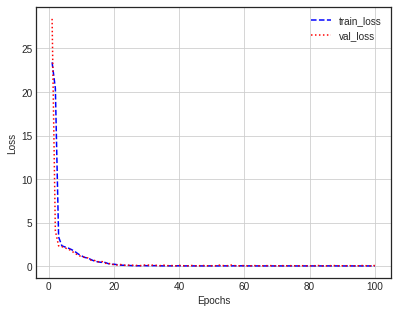

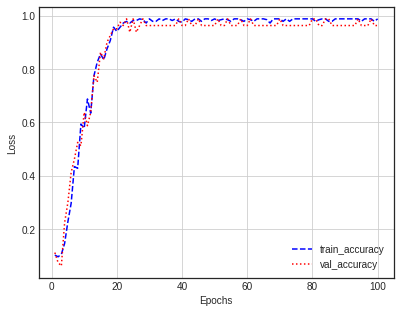

In [53]:
plot_history(hist.history)